In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from __future__ import unicode_literals
from IPython.core.display import display, HTML
import glob
from radical.entk import Profiler
import radical.analytics as ra
import radical.utils as ru
import radical.pilot as rp


pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 50)

%matplotlib inline
help(Profiler.duration)


Help on method duration in module radical.entk.utils.profiler:

duration(self, objects, states=None, events=None) unbound radical.entk.utils.profiler.Profiler method



/Users/JumanaDakka/environments/venv/lib/python2.7/site-packages/radical/utils/atfork/stdlib_fixer.py:63: UserWarning: logging module already imported before fixup.
  warnings.warn('logging module already imported before fixup.')


In [2]:
# Generate task uids

def get_task_uids(num_pipelines):
    
    num_tasks = 260
    task_uids = []
    for t in range(num_tasks):
        task_uids.append('radical.entk.task.%04d'%t)

    return task_uids

In [3]:

# Get information from all the entk profiles

def get_entk_info(pipelines):
    
    p = Profiler(src = './{0}_instances'.format(pipelines))
    
    task_uids = get_task_uids(pipelines)
    
    entk_dur = p.duration(task_uids, states=['SCHEDULING','DONE'])
    
    # Time taken in appmanager to rreq function call
    entk_core_1 = p.duration('radical.entk.appmanager.0000', events=['create amgr obj', 'init rreq submission'])
    
    # Time taken to tear down appmanager
    #entk_core_2 = p.duration('radical.entk.appmanager.0000', events=['start termination', 'termination done'])
    
    # Time taken to create resource manager obj
    entk_core_3 = p.duration('radical.entk.resource_manager.0000', events = ['create rmgr obj', 'rmgr obj created'])
    
    # Time taken to create and submit resource reservation
    entk_core_4 = p.duration('radical.entk.resource_manager.0000', events = ['creating rreq', 'rreq submitted'])
    
    # Time taken to deallocate resource reservation
    #entk_core_5 = p.duration('radical.entk.resource_manager.0000', events = ['canceling resource allocation', 'resource allocation cancelled'])
    
    entk_core_dur = entk_core_1 + entk_core_3 + entk_core_4
    
    #entk_core_dur = entk_core_1 + entk_core_2 + entk_core_3 
    
    #entk_total_dur = entk_dur_1 + entk_dur_2 + entk_core_dur
    
    return entk_core_dur

In [4]:
# Get information from all the rp profile files and json file
# returns 0,0 if no rp files are found

def get_rp_info(pipeline):

    rp_folder = glob.glob('./{0}_instances/rp.*'.format(pipeline))
    src = rp_folder[0]
    session = ra.Session(stype='radical.pilot', src=src)
    units = session.filter(etype='unit', inplace=False)
    pilots = session.filter(etype='pilot', inplace=False)
    exec_dur = units.duration([rp.AGENT_EXECUTING, rp.DONE])
    rp_dur = units.duration([rp.UMGR_SCHEDULING_PENDING, rp.DONE])
    task_exec_dur = []
    get_units = session.get(etype='unit')
    print len(get_units)
    
    #assert len(get_units) == pipeline*4

    sorted_units = sorted(units.list('uid'))
    # print sorted_units

    
    
    '''
    for x in range(0, pipeline*8, pipeline):
    #   print x
    #   print x + pipeline
    #   print sorted_units[x:x+pipeline]
        session = ra.Session(stype='radical.pilot', src=src)
        subset_units = session.filter(uid=sorted_units[x:x+pipeline])
        exec_dur = subset_units.duration([rp.AGENT_EXECUTING, rp.DONE])
        task_exec_dur.append(exec_dur)
        
    '''
    return rp_dur, exec_dur


In [6]:
df = pd.DataFrame(columns=['RP overhead', 'Execution duration'])
#df_stages = pd.DataFrame(columns=['Stage 1 (Instance 1)', 'Stage 1 (Instance 2)', 'Stage 2 (Instance 1)', 'Stage 2 (Instance 2)', 
                                  #'Stage 3 (Instance 1)', 'Stage 3 (Instance 2)','Stage 4 (Instance 1)', 'Stage 4 (Instance 1)'], ) 
pipelines_list = [2,4]

for pipelines in pipelines_list:
    #entk_dur = get_entk_info(pipelines)
    rp_dur, exec_dur = get_rp_info(pipelines)
    
    print rp_dur, 
    print exec_dur
    df.loc[pipelines] = [rp_dur - exec_dur, exec_dur]
    #df_stages.loc[pipelines] = task_exec_dur
df   
#df_stages

532
10761.1557 10754.7784998
1064
10477.0411 10472.5271001


,RP overhead,Execution duration
2,6.3772,10754.7785
4,4.5140,10472.5271


In [6]:
%matplotlib inline

In [43]:
'''
ax = df.plot(kind='bar', title='Time taken by EnTK and RP to execute a workflow consisting of \n X Pipelines, 7 Stages per Pipeline and 1 Task per Stage on NCSA.BW (Task executable = "sleep 0", number of trials per data point = 1)')
ax.set_xlabel('Number of Pipelines')
ax.set_ylabel('Time (seconds)')


fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('null_worload_devel.pdf', dpi=100)
'''

u'\nax = df.plot(kind=\'bar\', title=\'Time taken by EnTK and RP to execute a workflow consisting of \n X Pipelines, 7 Stages per Pipeline and 1 Task per Stage on NCSA.BW (Task executable = "sleep 0", number of trials per data point = 1)\')\nax.set_xlabel(\'Number of Pipelines\')\nax.set_ylabel(\'Time (seconds)\')\n\n\nfig = plt.gcf()\nfig.set_size_inches(18.5, 10.5)\nfig.savefig(\'null_worload_devel.pdf\', dpi=100)\n'

In [10]:
# Global configurations
# ---------------------

# Expand the notebook to the width of the browser
display(HTML("<style>.container { width:100% !important; }</style>"))

# Matplotlib style
plt.style.use('seaborn-colorblind')

# Use LaTeX and its body font for the diagrams' text.
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif']  = ['Nimbus Roman Becker No9L']

# Font sizes
SIZE = 24
plt.rc('font', size=SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)  # fontsize of the x any y labels
plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE-2)  # legend fontsize
plt.rc('figure', titlesize=SIZE)  # # size of the figure title

# Use thinner lines for axes to avoid distractions.
mpl.rcParams['axes.linewidth']    = 1
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['lines.linewidth'] = 2


# Do not use a box for the legend to avoid distractions.
mpl.rcParams['legend.frameon'] = False

# Restore part of matplotlib 1.5 behavior
mpl.rcParams['patch.force_edgecolor'] = True
mpl.rcParams['errorbar.capsize'] = 3

# Helpers
# -------

# Use coordinated colors. These are the "Tableau 20" colors as 
# RGB. Each pair is strong/light. For a theory of color    
tableau20 = [(31 , 119, 180), (174, 199, 232), # blue        [ 0,1 ]
             (255, 127, 14 ), (255, 187, 120), # orange      [ 2,3 ]
             (44 , 160, 44 ), (152, 223, 138), # green       [ 4,5 ]
             (214, 39 , 40 ), (255, 152, 150), # red         [ 6,7 ]
             (148, 103, 189), (197, 176, 213), # purple      [ 8,9 ]
             (140, 86 , 75 ), (196, 156, 148), # brown       [10,11]
             (227, 119, 194), (247, 182, 210), # pink        [12,13]
             (188, 189, 34 ), (219, 219, 141), # yellow      [14,15]
             (23 , 190, 207), (158, 218, 229), # cyan        [16,17]
             (65 , 68 , 81 ), (96 , 99 , 106), # gray        [18,19]
             (127, 127, 127), (143, 135, 130), # gray        [20,21] 
             (165, 172, 175), (199, 199, 199), # gray        [22,23]
             (207, 207, 207)]                   # gray        [24]
  
# Scale the RGB values to the [0, 1] range, which is the format 
# matplotlib accepts.    
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)    

# Return a single plot without right and top axes
def fig_setup():
    fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot(111)    
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    
    return fig, ax

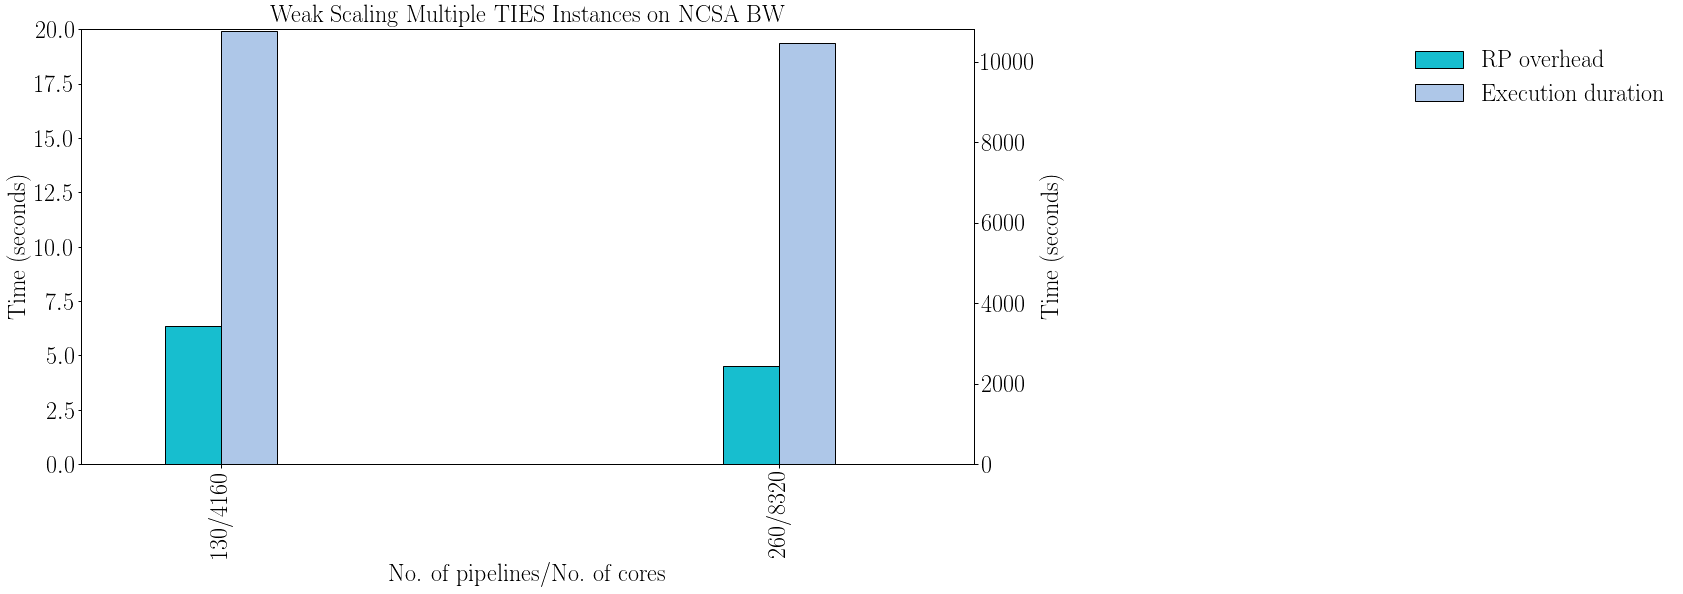

In [35]:
fig, ax = fig_setup()

width=0.1
ax = df.plot(kind='bar', 
             ax=ax,
             y=df.columns.drop('Execution duration').tolist(),
             #y=df.columns.drop('RP overhead'),
             fontsize=SIZE,
             width=width,
             position=1,
             color = [tableau20[(16)], tableau20[(20)]],
             title='Weak Scaling Multiple TIES Instances on NCSA BW',
             legend=False)


ax2 = df['Execution duration'].plot(ax=ax, stacked=True, secondary_y=True, color = [tableau20[(1)]], 
                        width=width, legend=False, position=0, kind = 'bar')
ax2.set_ylim(0,10800)

ax.set_ylim(0,20)
ax.set_xlabel('No. of pipelines/No. of cores', fontsize=SIZE)
ax.set_ylabel('Time (seconds)', fontsize=SIZE)
ax2.set_ylabel('Time (seconds)', fontsize=SIZE)
ax.set_xticklabels(['130/4160','260/8320'])                                                     
ax.set_title(ax.get_title(), fontsize=SIZE)

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
labels = l1 + l2 

handles = h1 + h2
plt.legend(handles,labels,fontsize=SIZE, bbox_to_anchor = (1.8,1))
plt.show()
fig.savefig('Weak Scaling Multiple TIES Instances on NCSA BW.pdf', dpi=100, bbox_inches='tight')